In [1]:
import os

assert os.environ['CONDA_DEFAULT_ENV']=='lk2'

## create files

In [2]:
import sys
sys.path.insert(0, '../code')
from utils import get_tois, get_ctois

tois = get_tois()

Loaded:  ../data/TOIs.csv


In [3]:
name='toi4323'
toiid=4323

In [4]:
d = tois[tois['TOI'].apply(str).str.contains(str(toiid))].reset_index()
d

,index,TIC ID,TOI,Previous CTOI,Master,SG1A,SG1B,SG2,SG3,SG4,...,Stellar Radius (R_Sun) err,Stellar Metallicity,Stellar Metallicity err,Stellar Mass (M_Sun),Stellar Mass (M_Sun) err,Sectors,Date TOI Alerted (UTC),Date TOI Updated (UTC),Date Modified,Comments
0,3612,143022742,4323.01,NaN,5,5,5,5,5,5,...,0.013602,NaN,NaN,0.455971,0.020254,"4,31",2021-07-27,2021-07-26,2022-12-14 12:09:24,potential L1 planet; low SNR; fit appears to b...
1,3613,143022742,4323.02,NaN,5,5,5,5,5,5,...,0.013602,NaN,NaN,0.455971,0.020254,"4,31",2021-07-27,2021-07-26,2022-12-14 12:09:24,possible 3:2 resonance; 3.6 sigma odd-even


In [5]:
tic = tois['TIC ID'].unique()[0]
tic

231663901

In [6]:
import numpy as np

G = 6.67e-11
D_H = 24.
D_M = 60 * D_H
D_S = 60 * D_M
au             = 1.496e11
msun           = 1.9891e30
rsun           = 0.5*1.392684e9

def as_from_rhop(rho, P):
    """Scaled semi-major axis from the stellar density and planet's orbital period.
    Parameters
    ----------
      rho    : stellar density [g/cm^3]
      period : orbital period  [d]
    Returns
    -------
      as : scaled semi-major axis [R_star]
    """
    return (G/(3*np.pi))**(1/3) * ((P * D_S)**2 * 1e3 * rho)**(1 / 3)

def a_from_rhoprs(rho, P, rstar):
    """Semi-major axis from the stellar density, stellar radius, and planet's orbital period.
    Parameters
    ----------
      rho    : stellar density [g/cm^3]
      period : orbital period  [d]
      rstar  : stellar radius  [R_Sun]
    Returns
    -------
      a : semi-major axis [AU]
    """
    return as_from_rhop(rho, P)*rstar*rsun/au

def rhostar(mstar, rstar):
    vol = 4/3*np.pi*rstar**3
    return mstar/vol
    
def estimate_ttv_super_period_of_first_order_mmr(P1, P2, MMR='2:1'):
    '''
    Estimates the TTV super-period.
    Only works for first order MMRs, e.g., 2:1, 3:2, 4:3, etc.
    Following Eq. 7 of Lithwick+ 2017, https://iopscience.iop.org/article/10.1088/0004-637X/761/2/122/pdf
    
    Parameters
    ----------
    P1 : float
        Orbital period of the inner planet.
    P2 : float
        Orbital period of the outer planet.
    MMR : str, optional
        Mean motion resonance. 
        The larger number must come first.
        The default is '2:1'.
    Returns
    -------
    TTV super-period : float
        The TTV super-period.
    '''
    
    j = int(MMR.split(':')[0])
    return 1. / np.abs( (1.*j/P2) - (1.*(j-1.)/P1) )

def catalog_info_TIC(TIC_ID):
    """Takes TIC_ID, returns stellar information from online catalog using Vizier
    
    Taken from 
    https://github.com/hippke/tls/blob/master/transitleastsquares/catalog.py#L64
    """
    if type(TIC_ID) is not int:
        raise TypeError('TIC_ID ID must be of type "int"')
    try:
        from astroquery.mast import Catalogs
    except:
        raise ImportError("Package astroquery required but failed to import")

    result = Catalogs.query_criteria(catalog="Tic", ID=TIC_ID).as_array()
    Teff = result[0][64]
    logg = result[0][66]
    radius = result[0][70]
    radius_max = result[0][71]
    radius_min = result[0][71]
    mass = result[0][72]
    mass_max = result[0][73]
    mass_min = result[0][73]
    return Teff, logg, radius, radius_min, radius_max, mass, mass_min, mass_max

In [7]:
estimate_ttv_super_period_of_first_order_mmr(5, 2.5, MMR='2:1')

1.6666666666666665

In [8]:
Teff, logg, radius, radius_min, radius_max, mass, mass_min, mass_max = catalog_info_TIC(143022742)
Teff, logg, radius, radius_min, radius_max, mass, mass_min, mass_max

(3414.0,
 4.77364,
 0.458861,
 0.0136024,
 0.0136024,
 0.455971,
 0.0202541,
 0.0202541)

In [9]:
!mkdir ../allesfitter/$name

mkdir: cannot create directory ‘../allesfitter/toi4323’: File exists


In [10]:
import numpy as np

debug = False

Nsamples = 10_000
planets = "b c d e f g".split()
# quartiles = [16,50,84] #1-sigma
quartiles = [2.70, 50, 97.3] #3-sigma
text = """
#name,value,fit,bounds,label,unit,truth
"""

for i,row in d.iterrows():
    tic = row['TIC ID']
    Porb = row['Period (days)']
    Porberr = row['Period (days) err']
    Porb_s = np.random.normal(Porb, Porberr, size=Nsamples)
    epoch = row['Epoch (BJD)']
    epocherr = row['Epoch (BJD) err']
    
    pl = planets[i]
    rprs = np.sqrt(row['Depth (ppm)']/1e6)
    rprserr = np.sqrt(row['Depth (ppm) err']/1e6)
    
    rprs_s = np.random.normal(rprs, rprserr, size=Nsamples)
    rprs_min, rprs, rprs_max = np.percentile(rprs_s, q=quartiles)
    
    Teff, logg, radius, radius_min, radius_max, mass, mass_min, mass_max = catalog_info_TIC(tic)
    
    mass_s = np.random.normal(mass, np.sqrt(mass_min**2+mass_max**2), size=Nsamples)
    radius_s = np.random.normal(mass, np.sqrt(radius_min**2+radius_max**2), size=Nsamples)
    
    rho_s = rhostar(mass_s, radius_s)
    rhomin, rho, rhomax = np.percentile(rho_s, q=quartiles)
    
    as_s = as_from_rhop(rho_s, Porb_s)
    as_min, a, as_max = np.percentile(as_s, q=quartiles)
    
    rsuma_s = radius_s/as_s
    rsuma_min, rsuma, rsuma_max = np.percentile(rsuma_s, q=quartiles)
    
    theta = np.arcsin(radius_s/as_s)
    inc_s = np.pi/2 - theta
    inc_max, inc, inc_min = np.percentile(inc_s, q=quartiles)
#     b_s = as_s * np.cos(inc_s)
#     b_min, b, b_max = np.percentile(b_s, q=quartiles)
    
    text += f"#companion {pl} astrophysical params,,,,,,\n"
    text += f"{pl}_rr,{rprs:.4f},1,uniform {rprs_min:.4f} {rprs_max:.4f},$R_{pl} / R_\star$,,\n"
    text += f"{pl}_rsuma,{rsuma:.4f},1,uniform {rsuma_min:.4f} {rsuma_max:.4f},$(R_\star + R_{pl}) / a_{pl}$,,\n"
    text += f"{pl}_cosi,{np.cos(inc):.4f},1,uniform {np.cos(inc_min):.4f} {np.cos(inc_max):.4f},$\cos"+"{i_"+pl+"}$,,\n"
#     text += f"{pl}_epoch,{epoch:.2f},1,uniform {epoch-epoch_err:.4f} {epoch+epoch_err:.4f},$T_"+"{0;"+pl+"}$,BJD,"
    text += f"{pl}_epoch,{epoch:.2f},1,normal {epoch:.4f} {epocherr:.4f},$T_"+"{0;"+pl+"}$,BJD,\n"
    text += f"{pl}_period,{Porb:.4f},1,normal {Porb:.4f} {Porberr:.4f},$P_b$,d,\n"
    if debug:
        print(pl)
        print(f"rprs={rprs:.4f}")
        print(f"rho={rho:.4f}")
        print(f"a={a:.4f}")
        print(f"rsuma={rsuma:.4f}")
        print(f"inc={np.rad2deg(inc):.2f}")
#         print(f"b={b:.2f}")
text += """b_f_c,0,0,uniform 0.0 0.0,$\sqrt{e_b} \cos{\omega_b}$,,
b_f_s,0,0,uniform 0.0 0.0,$\sqrt{e_b} \sin{\omega_b}$,,
#limb darkening coefficients per instrument,,,,,,
host_ldc_q1_tess,0.5,1,uniform 0.0 1.0,$q_{1; \mathrm{tess}}$,,
host_ldc_q2_tess,0.5,1,uniform 0.0 1.0,$q_{2; \mathrm{tess}}$,,
#errors per instrument,,,,,,
log_err_flux_tess,-6,1,uniform -10 -1,$\log{\sigma_\mathrm{tess}}$,rel. flux,
#baseline per instrument,,,,,,
baseline_gp_offset_flux_tess,0,1,uniform -0.1 0.1,$\mathrm{gp ln sigma (tess)}$,,
baseline_gp_matern32_lnsigma_flux_tess,-5,1,uniform -15 0,$\mathrm{gp ln sigma (tess)}$,,
baseline_gp_matern32_lnrho_flux_tess,0,1,uniform -1 15,$\mathrm{gp ln rho (tess)}$,,
"""
# print(text)

In [11]:
fp = f"../allesfitter/{name}/params.csv"
np.savetxt(fp, [text], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi4323/params.csv


In [12]:
!cat $fp


#name,value,fit,bounds,label,unit,truth
#companion b astrophysical params,,,,,,
b_rr,0.0592,1,uniform -0.0016 0.1219,$R_b / R_\star$,,
b_rsuma,0.0194,1,uniform 0.0163 0.0227,$(R_\star + R_b) / a_b$,,
b_cosi,0.0194,1,uniform 0.0163 0.0227,$\cos{i_b}$,,
b_epoch,2458416.55,1,normal 2458416.5481 0.0132,$T_{0;b}$,BJD,
b_period,14.6763,1,normal 14.6763 0.0003,$P_b$,d,
#companion c astrophysical params,,,,,,
c_rr,0.0891,1,uniform 0.0208 0.1576,$R_c / R_\star$,,
c_rsuma,0.0148,1,uniform 0.0124 0.0174,$(R_\star + R_c) / a_c$,,
c_cosi,0.0148,1,uniform 0.0124 0.0174,$\cos{i_c}$,,
c_epoch,2458412.90,1,normal 2458412.8965 0.0065,$T_{0;c}$,BJD,
c_period,21.9693,1,normal 21.9693 0.0003,$P_b$,d,
b_f_c,0,0,uniform 0.0 0.0,$\sqrt{e_b} \cos{\omega_b}$,,
b_f_s,0,0,uniform 0.0 0.0,$\sqrt{e_b} \sin{\omega_b}$,,
#limb darkening coefficients per instrument,,,,,,
host_ldc_q1_tess,0.5,1,uniform 0.0 1.0,$q_{1; \mathrm{tess}}$,,
host_ldc_q2_tess,0.5,1,uniform 0.0 1.0,$q_{2; \mathrm{tess}}$,,
#errors per instrume

In [13]:
text2="""#name,value
###############################################################################,
# General settings,
###############################################################################,
companions_phot,b c
companions_rv,
inst_phot,tess
inst_rv,
###############################################################################,
# Fit performance settings,
###############################################################################,
multiprocess,True
multiprocess_cores,40
fast_fit,True
fast_fit_width,0.3333333333333333
secondary_eclipse,False
phase_curve,False
shift_epoch,True
inst_for_b_epoch,all
###############################################################################,
# MCMC settings,
###############################################################################,
mcmc_nwalkers,100
#mcmc_nwalkers,200
mcmc_total_steps,2000
#mcmc_total_steps,6000
mcmc_burn_steps,1000
#mcmc_burn_steps,1000
#mcmc_thin_by,20
mcmc_thin_by,2
###############################################################################,
# Nested Sampling settings,
###############################################################################,
ns_modus,dynamic
ns_nlive,1000
ns_bound,single
ns_sample,rwalk
ns_tol,0.01
###############################################################################,
# Limb darkening law per object and instrument,
###############################################################################,
host_ld_law_tess,quad
###############################################################################,
# Baseline settings per instrument,
###############################################################################,
#baseline_flux_tess,sample_offset
#baseline_flux_tess,hybrid_spline
#baseline_flux_tess,hybrid_poly_2
baseline_flux_tess,sample_GP_Matern32
###############################################################################,
# Error settings per instrument,
###############################################################################,
error_flux_tess,sample
###############################################################################,
# Stellar grid per object and instrument,
###############################################################################,
host_grid_tess,very_sparse
###############################################################################,
# Flares,
###############################################################################,
#N_flares,1
use_host_density_prior,False
###################################################,
# fit_ttvs
###################################################,
fit_ttvs,False
t_exp,"""

In [14]:
fp = f"../allesfitter/{name}/settings.csv"
np.savetxt(fp, [text2], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi4323/settings.csv


In [15]:
text3="""#!/usr/bin/env python
import allesfitter

fig = allesfitter.show_initial_guess('.')
#allesfitter.prepare_ttv_fit('.')

allesfitter.ns_fit('.')
allesfitter.ns_output('.')"""

In [16]:
fp = f"../allesfitter/{name}/run.py"
np.savetxt(fp, [text3], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi4323/run.py


/home/jp/miniconda3/envs/lk2/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/jp/.lightkurve/cache. Please move all the files in the legacy directory /home/jp/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


NameError: name 'toi' is not defined

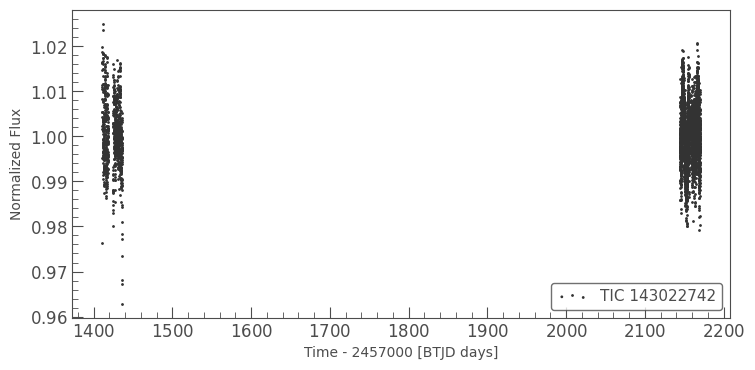

In [17]:
#!/usr/bin/env python
import lightkurve as lk

multi_sector = True
cols = ['time','flux','flux_err']

result = lk.search_lightcurve(f'TIC {tic}', author='TESS-SPOC')
if result:
    if multi_sector:
        lc = result.download_all().stitch()
    else:
        lc = result.download().normalize()
    ax = lc.scatter()
    #ax.set_title(f"TOI {toi} (sector {lc.sector})")
    ax.figure.savefig(f"../allesfitter/{name}/toi{toi}_tess.png")
    fp = f"../allesfitter/{name}/tess.csv"
    df = lc.to_pandas()
    df['time'] = df.index + 2457000
    df = df[cols].dropna()
    #import pdb; pdb.set_trace()
    df.to_csv(fp, sep=',', header=False, index=False)
    print("Saved: ", fp)
    print(df.head())